- `mamba install satpy s3fs netcdf4 h5netcdf` for satpy download data from AWS
- `pip install mpl_interactions[jupyter]` interactivate matplotlib figure

In [1]:
from satpy import Scene
from datetime import datetime

In [2]:
def goes16_file(dt, channels):
    print(f'target GOES-16 slot: {dt} with channels: {channels}')
    return [f's3://noaa-goes16/ABI-L1b-RadF/{dt:%Y}/{dt:%j}/{dt:%H}/*{c}_G16_s{dt:%Y%j%H%M}*' for c in channels]

In [3]:
reader_kwargs = {
    'storage_options': {
        's3': {'anon': True},
    }
}

## set datetime and channels

In [4]:
dt = '2024-01-07T08:50'
channels = ['C07', 'C13', 'C16'] # 3.9, 10.3, 13.3

## load dataset from AWS

In [5]:
dt = datetime.strptime(dt, '%Y-%m-%dT%H:%M')
filenames = goes16_file(dt, channels)
print(filenames)

target GOES-16 slot: 2024-01-07 08:50:00 with channels: ['C07', 'C13', 'C16']
['s3://noaa-goes16/ABI-L1b-RadF/2024/007/08/*C07_G16_s20240070850*', 's3://noaa-goes16/ABI-L1b-RadF/2024/007/08/*C13_G16_s20240070850*', 's3://noaa-goes16/ABI-L1b-RadF/2024/007/08/*C16_G16_s20240070850*']


In [6]:
scn = Scene(reader='abi_l1b', filenames=filenames, reader_kwargs=reader_kwargs)
# print(scn)

In [7]:
print(f'load channels: {channels}')
scn.load(channels)

load channels: ['C07', 'C13', 'C16']


In [8]:
bt039, bt103, bt133 = scn['C07'], scn['C13'], scn['C16']

In [9]:
bt_diff = bt039 - bt103

## plot image

In [10]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_interactions import zoom_factory
from mpl_interactions import ipyplot as iplt
import numpy as np
import warnings

In [11]:
kw = {'interpolation': 'nearest', 'origin': 'upper'}

In [12]:
idx = (np.array([3458, 3329]), np.array([3610, 2185])) # fire pixels

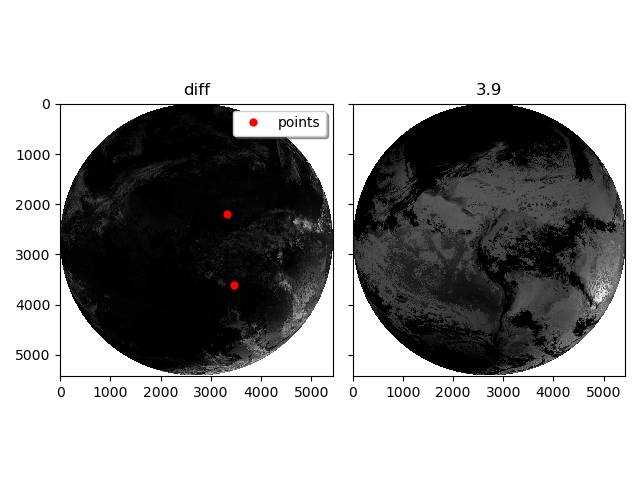

In [13]:
with plt.ioff():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

with warnings.catch_warnings(action="ignore"):
    # r
    im0 = iplt.imshow(bt_diff, ax=ax[0], vmin_vmax=("r", 0, bt_diff.max()), cmap='gray', **kw)
    (pts,) = ax[0].plot(idx[0], idx[1], linestyle="none", marker="o", markerfacecolor="red", markeredgecolor='None', label='points')
    leg = ax[0].legend(fancybox=True, shadow=True)
    ax[0].title.set_text('diff')
    # g
    im1 = iplt.imshow(bt039, ax=ax[1], vmin_vmax=("r", 273, bt039.max()), cmap='gray', **kw)
    ax[1].title.set_text('3.9')
    #
    shapes = [pts]
    map_legend_to_ax = {}  # Will map legend lines to original lines.
    
    pickradius = 5  # Points (Pt). How close the click needs to be to trigger an event.
    
    for legend_line, ax_shape in zip(leg.get_lines(), shapes):
        legend_line.set_picker(pickradius)  # Enable picking on the legend line.
        map_legend_to_ax[legend_line] = ax_shape
    
    def on_pick(event):
        # On the pick event, find the original line corresponding to the legend
        # proxy line, and toggle its visibility.
        legend_line = event.artist
    
        # Do nothing if the source of the event is not a legend line.
        if legend_line not in map_legend_to_ax:
            return
    
        ax_shape = map_legend_to_ax[legend_line]
        visible = not ax_shape.get_visible()
        ax_shape.set_visible(visible)
        # Change the alpha on the line in the legend, so we can see what lines
        # have been toggled.
        legend_line.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()
    
    fig.canvas.mpl_connect('pick_event', on_pick)
    leg.set_draggable(True)
    plt.tight_layout()
    
    disconnect_zoom = [zoom_factory(a) for a in ax]
    display(fig.canvas)